# Interactive Analysis
One need for bioimage analysts is to interactivly perform analysis on images. This interaction could be manual parameter tuning, such as adjusting thresholds, or performing human-in-the-loop analysis through clicking on specific regions of an image.

**[napari](https://napari.org/)** makes such interactive analyses easy because of it's easy coupling with Python and Scientific Python ecosystem, including tools like **[numpy](https://numpy.org/)** and **[scikit-image](https://scikit-image.org/)**.

## Setup

As was explained in the image visaulation tutorial, napari uses Qt for Graphical User Interface (GUI) so we must first create the Qt application before we can get started with `napari`.

In [1]:
%gui qt

We can then import `napari`, our `nbscreenshot` utility, example data from `skimage` and instantiate an empty viewer.

In [2]:
import napari
from napari.utils import nbscreenshot
import trackpy as tp
from skimage import data

# Create an empty viewer
viewer = napari.Viewer()

Let's read the original image from previous lessons, take a maximum projection, and view it in napari:

In [3]:
cells = data.cells3d()
membrane = cells[:,0,::].squeeze()
nuclei = cells[:,-1::]
nuclei = nuclei.squeeze()
nuclei_mip = nuclei.max(axis=0)
viewer.add_image(nuclei_mip)
viewer.add_image(membrane)
viewer.add_image(nuclei);

We can actualy chain commands together, just becareful as sometimes it can get difficult to keep track of all the things you are doing in the chain of commands

In [4]:
nuclei_mip = data.cells3d()[:,-1::].squeeze().max(axis=0)

Sometimes it is easier to break things into individual cells to reuse later.

In [5]:
viewer.add_image(nuclei_mip, name='chained');

If you have your data stored as a tif (or series of tifs) you can load them in this way. 

In [ ]:
#from tifffile import imread

## load the image data and inspect its shape
#nuclei_mip = imread('data/nuclei.tif').max(axis=0)
#viewer.add_image(nuclei_mip);
#print(nuclei_mip.shape)

In [ ]:
nbscreenshot(viewer)

## Visualizing image filtering results

One common task in image processing in **image filtering** which can be used to denoise an image or detect edges or other features.

We can use **napari** to visualize the results of some of the image filters that come with the **scikit-image** library.

In [6]:
# Import scikit-image's filtering module
from skimage import filters

In [7]:
viewer.add_image(filters.sobel_h(nuclei_mip), name='Horizontal Sobel');
viewer.add_image(filters.sobel_v(nuclei_mip), name='Vertical Sobel');
viewer.add_image(filters.roberts(nuclei_mip), name='Roberts');
viewer.add_image(filters.prewitt(nuclei_mip), name='Prewitt');
viewer.add_image(filters.scharr(nuclei_mip), name='Scharr');

In [ ]:
nbscreenshot(viewer)

In [8]:
# Keep only the nuclei mip layer
for l in viewer.layers[1:]:
    viewer.layers.remove(l)

## Interactive segmentation

Let's now perform an interactive segmentation of the nuclei using processing utilities from scikit-image.

In [9]:
from skimage import morphology
from skimage import feature
from skimage import measure
from skimage import segmentation
from scipy import ndimage
import numpy as np

First let's try and seperate background from foreground using a threhold. Here we'll use an automatically calculated threshold.

In [10]:
foreground = nuclei_mip >= filters.threshold_li(nuclei_mip)
viewer.add_labels(foreground, opacity=0.4);

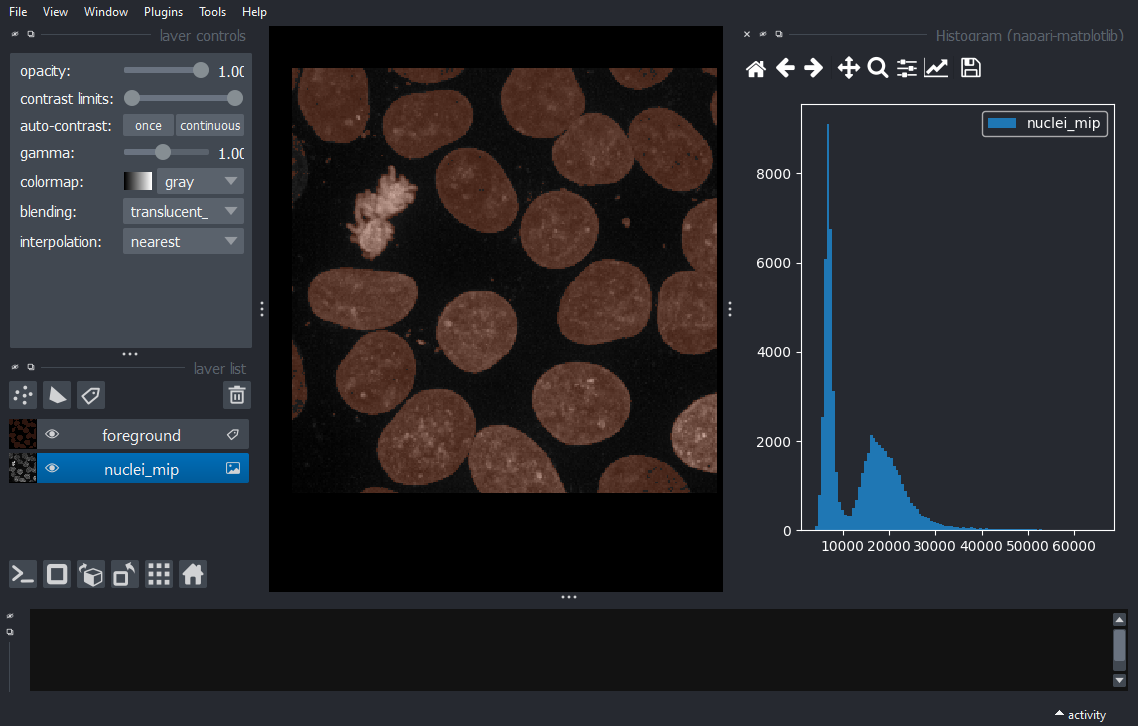

In [12]:
nbscreenshot(viewer)

Notice the debris located outside the nuclei and some of the holes located inside the nuclei. We will remove the debris by filtering out small objects, and fill the holes using a hole filling algorithm. We can update the data in the viewer in place.

In [11]:
foreground_processed = morphology.remove_small_holes(foreground, 60)
foreground_processed = morphology.remove_small_objects(foreground_processed, min_size=50)

viewer.layers['foreground'].data = foreground_processed

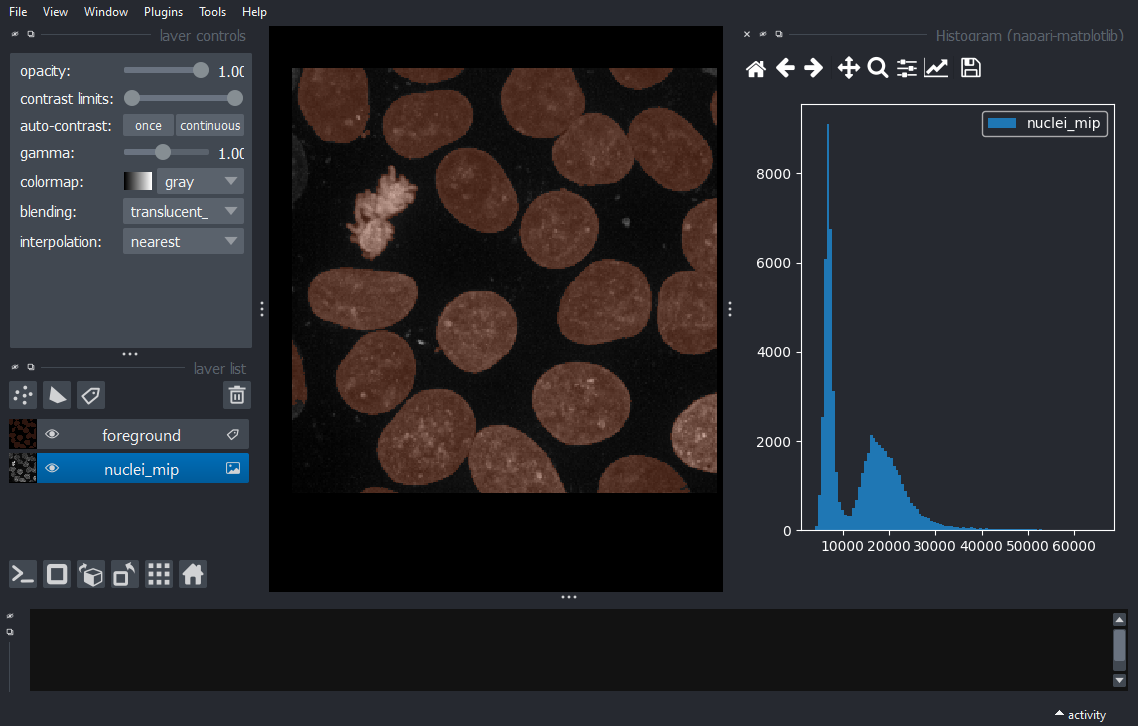

In [14]:
nbscreenshot(viewer)

## We will now convert this binary mask into an **instance segmentation** where each nuclei is assigned a unique label.

We will do this using a **marker controlled watershed** approach. The first step in this procedure is to calculate a distance transform on the binary mask as follows.

In [15]:
distance = ndimage.distance_transform_edt(foreground_processed)
viewer.add_image(distance);

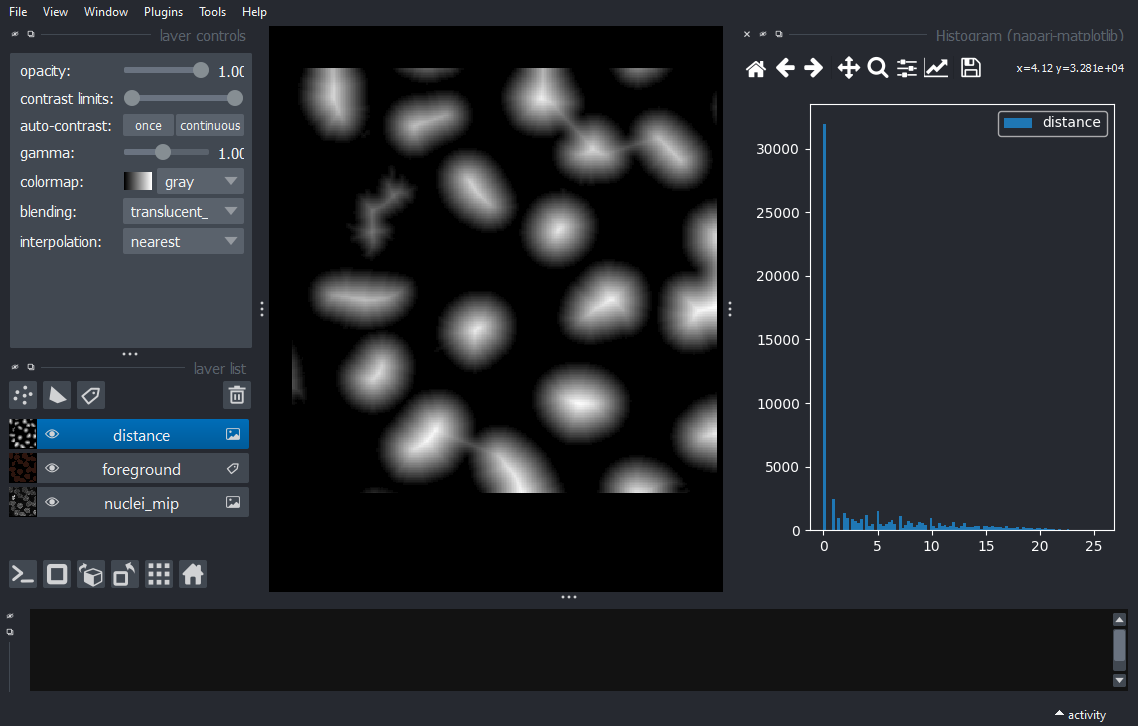

In [16]:
nbscreenshot(viewer)

We'll actually want to smooth the distance transform to avoid over segmentation artifacts. We can do this on the data in the viewer in place.

In [17]:
smoothed_distance = filters.gaussian(distance, 10)
viewer.layers['distance'].data = smoothed_distance

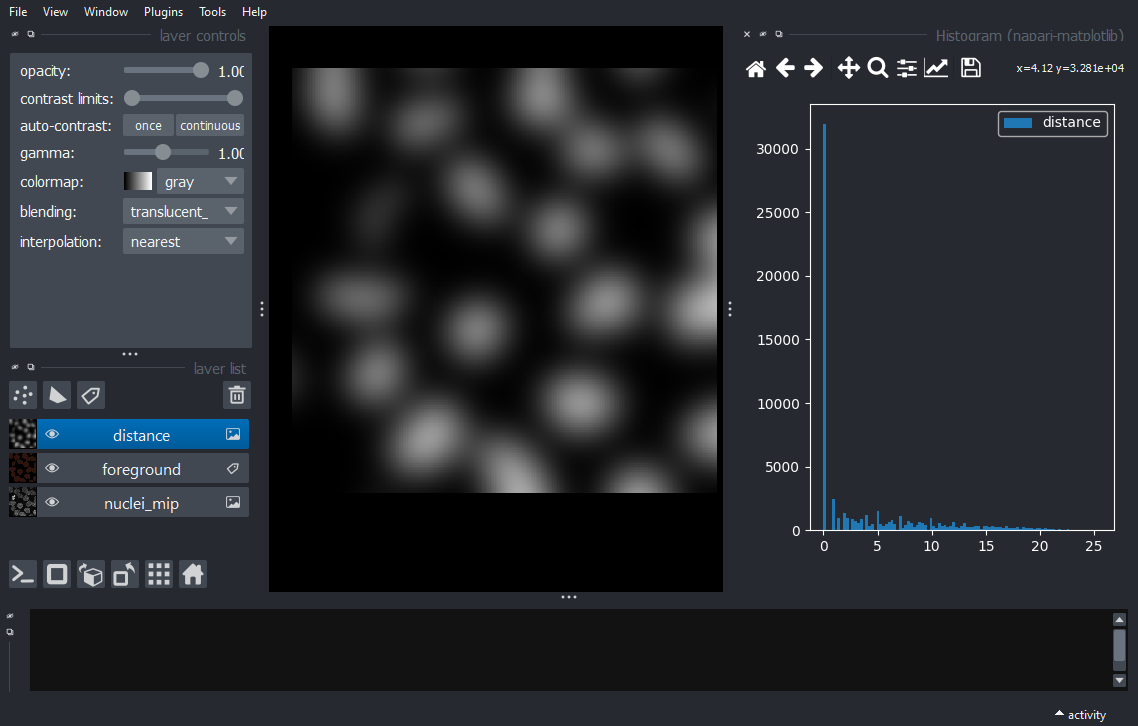

In [18]:
nbscreenshot(viewer)

Now we can try and identify the centers of each of the nuclei by finding peaks of the distance transform 

In [19]:
coordinates = feature.peak_local_max(distance,min_distance=20)
viewer.add_points(coordinates,name='peaks',size=5,face_color='lightblue')

<Points layer 'peaks' at 0x1a9d3deaca0>

c:\Apps\anaconda3\envs\napari-env\lib\site-packages\napari\_qt\qt_main_window.py:184: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  return super().event(e)
C:\Users\bscott\AppData\Roaming\Python\Python39\site-packages\ipykernel\eventloops.py:105: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  app.exec_()


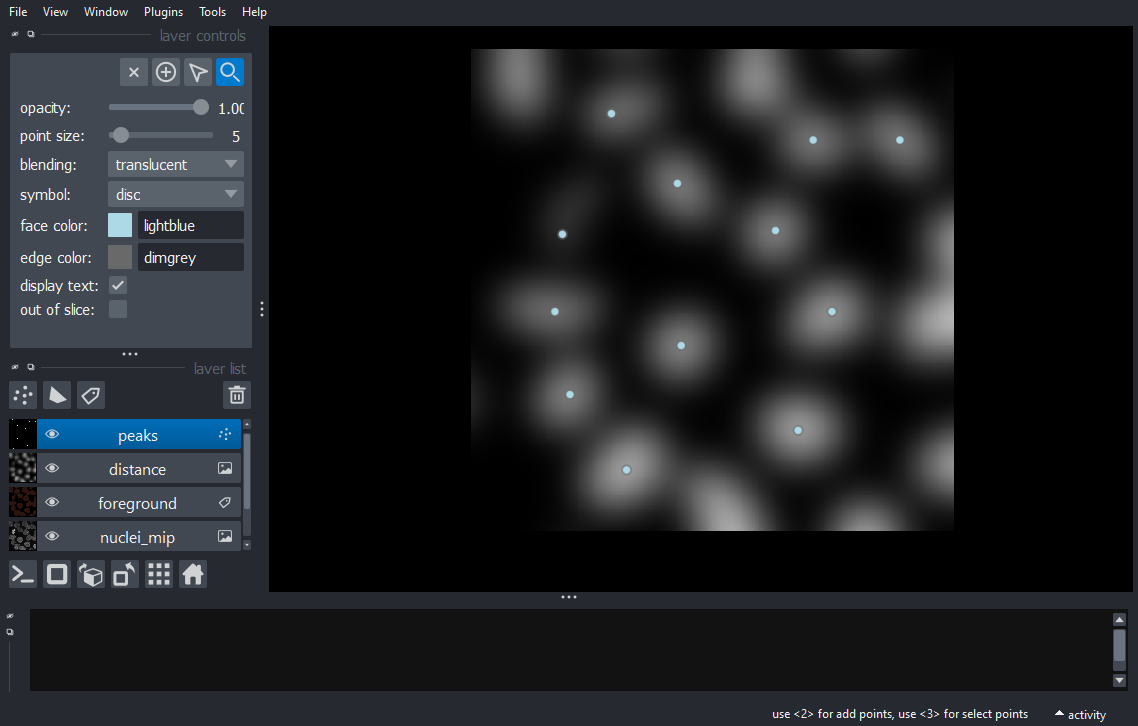

In [20]:
nbscreenshot(viewer)

## This representation isn't super informative

A better approach is to show the foreground image that we used initially. This is done by hiding the distance layer.

In [21]:
viewer.layers['distance'].visible=False

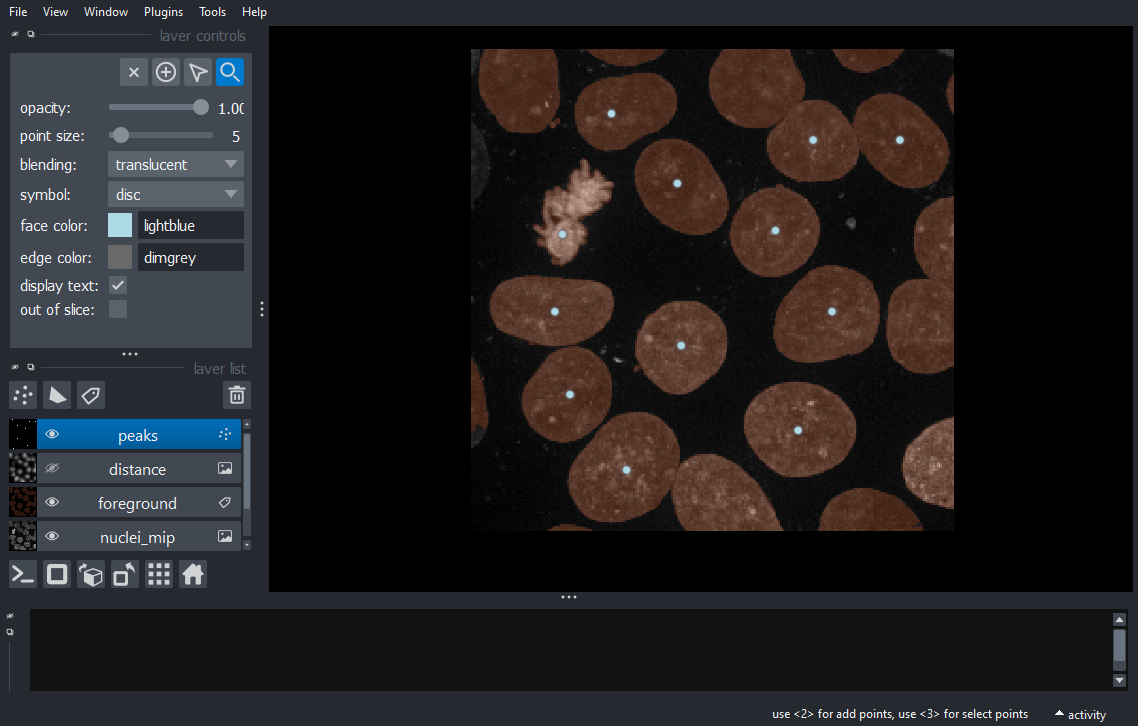

In [22]:
nbscreenshot(viewer)

We can now remove any of the points that don't correspond to nuclei centers or add any new ones using the GUI.

Changing the color isn't necessary, it just helps to distinguish the ones we added.

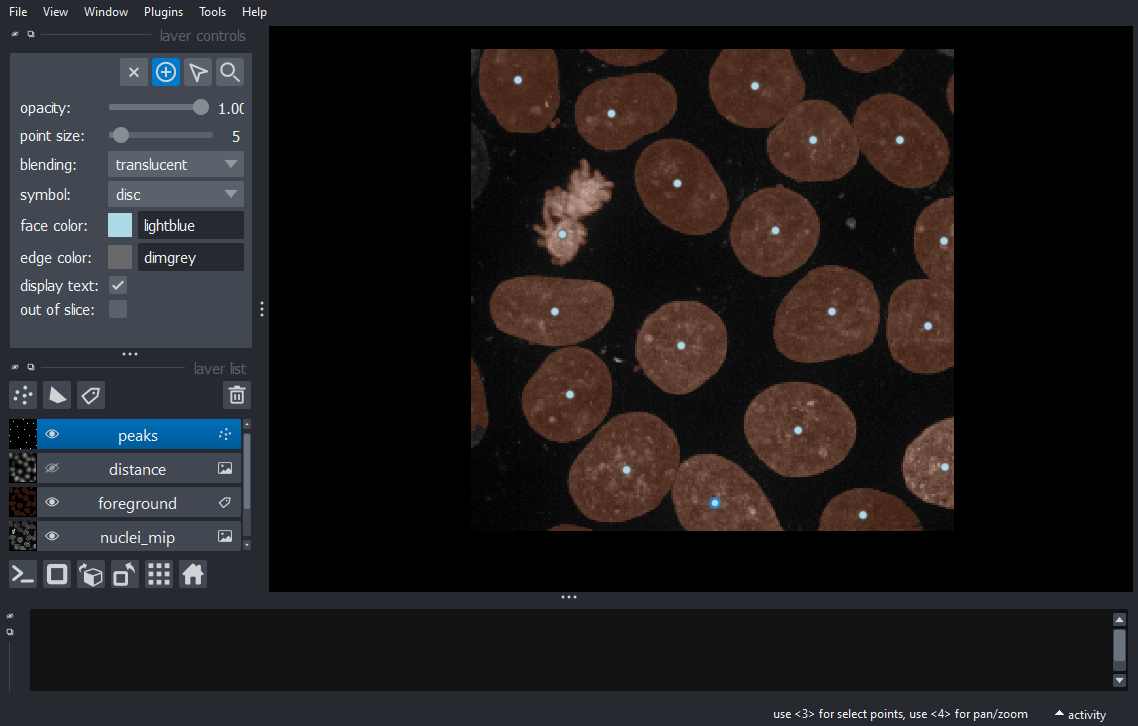

In [23]:
nbscreenshot(viewer)

Based on those peaks we can now seed the watershed algorithm which will find the nuclei boundaries.

In [26]:
new_peaks = np.round(viewer.layers['peaks'].data).astype(int).T
seeds = np.zeros(nuclei_mip.shape, dtype=bool)
seeds[(new_peaks[0], new_peaks[1])] = 1

markers = measure.label(seeds)
nuclei_segmentation = segmentation.watershed(
    -smoothed_distance, 
    markers, 
    mask=foreground_processed
)

viewer.add_labels(nuclei_segmentation, opacity=0.4);

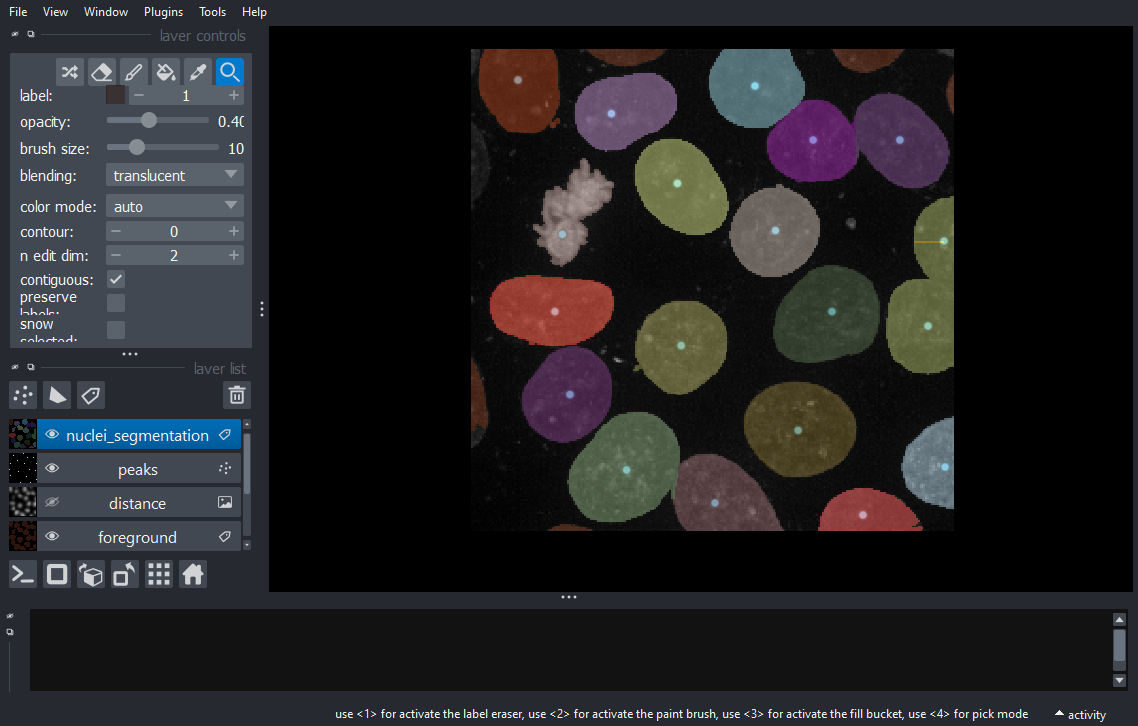

In [25]:
nbscreenshot(viewer)

## At this point, you can easily add or remove additional points and rerun the segmentation cell.

Maybe we don't want to segment the dividing cell?

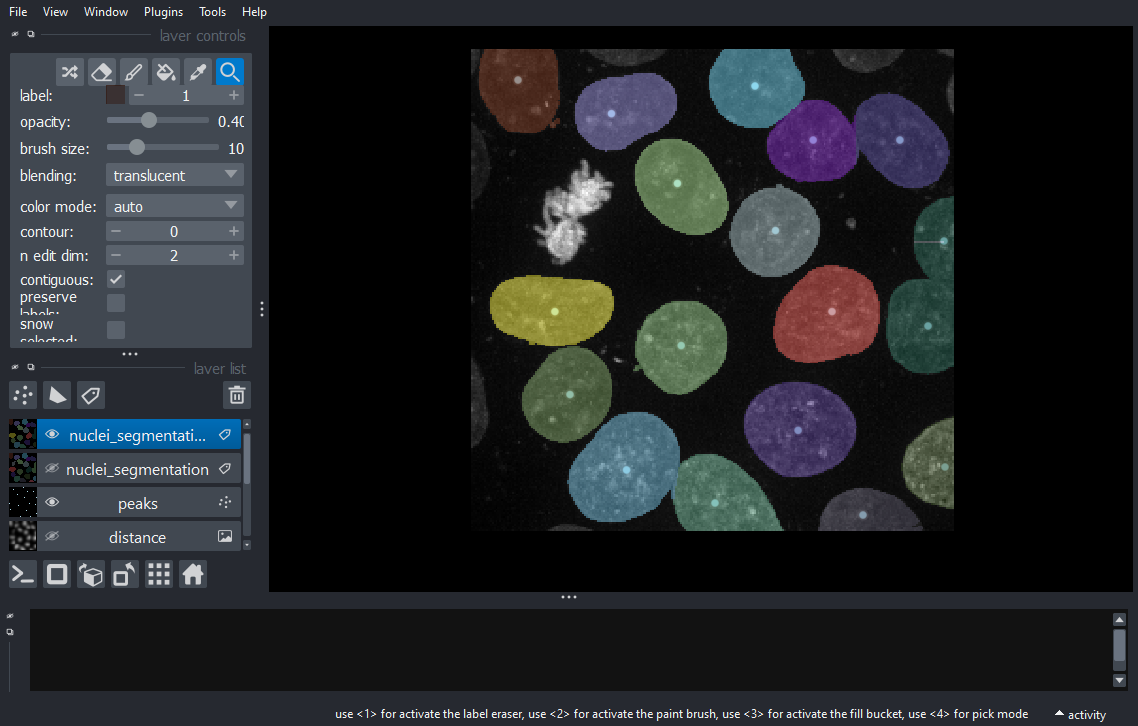

In [27]:
nbscreenshot(viewer)

We can now save our segmentation using our builtin save method.

In [ ]:
viewer.layers['nuclei_segmentation'].save('nuclei-automated-segmentation.tif', plugin='napari');

## Interactive thresholding with a custom GUI element

Interactivity can be greatly enhanced by custom GUI elements like slides and push buttons, custom mouse functions, or custom keybindings. **[napari](https://napari.org/)** can easliy be exteneded with these features, and a companion library **[magicgui](https://magicgui.readthedocs.io/en/latest/)** maintained by the napari team allows users to make extensions to the GUI without having to write any GUI code.

We'll now explore adding such interactivty to **napari**.

In [12]:
# Remove all processed layers
for l in viewer.layers[1:]:
    viewer.layers.remove(l)

In [13]:
# Import magicgui and qt functionality
from magicgui import magicgui

In [14]:
from napari.types import LabelsData, ImageData

@magicgui(call_button='Run Threshold')
def threshold(image: ImageData, threshold: int = 10000) -> LabelsData:
    """Threshold an image and return a mask."""
    return (image > threshold).astype(int)

viewer.window.add_dock_widget(threshold)
threshold();  # "call the widget" to call the function.
             # Normally this would be caused by some user UI interaction

## Now that wasn't super user-friendly. How about we try again.

In [15]:
from napari.types import LabelsData
from napari.layers import Image
@magicgui(call_button='Run Threshold Low')
def threshold(image: Image) -> LabelsData:
    """Threshold an image and return a mask."""
    threshold= image.contrast_limits[0]
    return (image.data > threshold).astype(int)

viewer.window.add_dock_widget(threshold)
threshold();  # "call the widget" to call the function.
             # Normally this would be caused by some user UI interaction

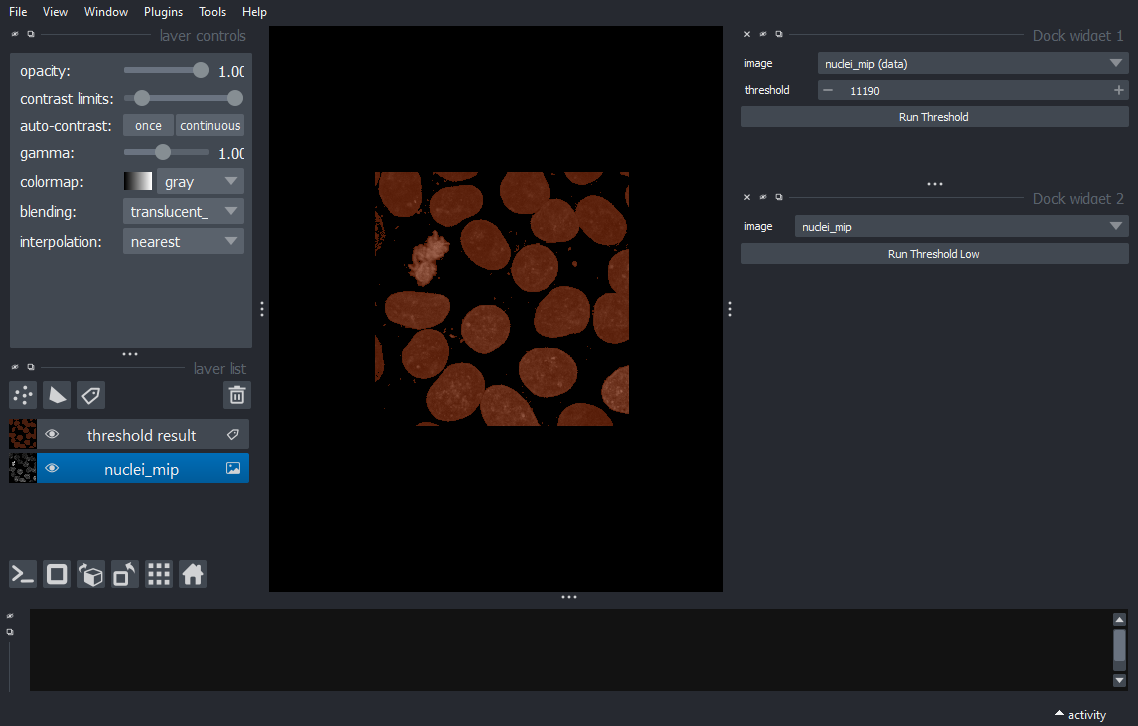

In [32]:
nbscreenshot(viewer)

We can make a slider that automatically updates the thresholding

In [26]:
from magicgui import magicgui
from napari.types import LabelsData
from napari.layers import Image


@magicgui(threshold={'widget_type': 'FloatSlider', 'value': 0.2, 'min': 0, 'max': 65000}, auto_call=True)
def threshold_wdg(image: Image, threshold: float) -> LabelsData:
    """Threshold an image and return a mask."""
    return (image.data > threshold)


def update_range():
    threshold_wdg.threshold.max = threshold_wdg.image.value.contrast_limits[1]

viewer.window.add_dock_widget(threshold_wdg, name='Threshold Intensity')

threshold_wdg()  # "call the widget" to call the function.
# Normally this would be caused by some user UI interaction
threshold_wdg.image.changed.connect(update_range);


In [17]:
## Adding a custom key binding to the viewer for processing foreground data
@viewer.bind_key('Shift-P',overwrite=True)
def process_foreground(viewer):
    data = viewer.layers['threshold result'].data
    data_processed = morphology.remove_small_holes(data, 60)
    data_processed = morphology.remove_small_objects(data_processed, min_size=50).astype(bool)
    viewer.layers['threshold result'].data = data_processed

## Actual python functions are allowed to be created to do something useful.

Here create `segment_nuclei` and turn it into a widget.

In [18]:
from napari.types import LabelsData
from napari.layers import Image
@magicgui(call_button='Segment Nuclei')
def segment_nuclei(foreground: LabelsData) -> LabelsData:
    distance = ndimage.distance_transform_edt(foreground)
    distance = filters.gaussian(distance, 10)
    coordinates = feature.peak_local_max(distance,min_distance=20)
    markers = measure.label(coordinates)
    viewer.add_points(coordinates,name='peaks',size=5,face_color='lightblue')
    new_peaks = np.round(viewer.layers['peaks'].data).astype(int).T
    seeds = np.zeros(nuclei_mip.shape, dtype=bool)
    seeds[(new_peaks[0], new_peaks[1])] = 1
    markers = measure.label(seeds)
    nuclei_segmentation = segmentation.watershed(-distance, markers, mask=foreground)
    return nuclei_segmentation
viewer.window.add_dock_widget(segment_nuclei)
segment_nuclei();

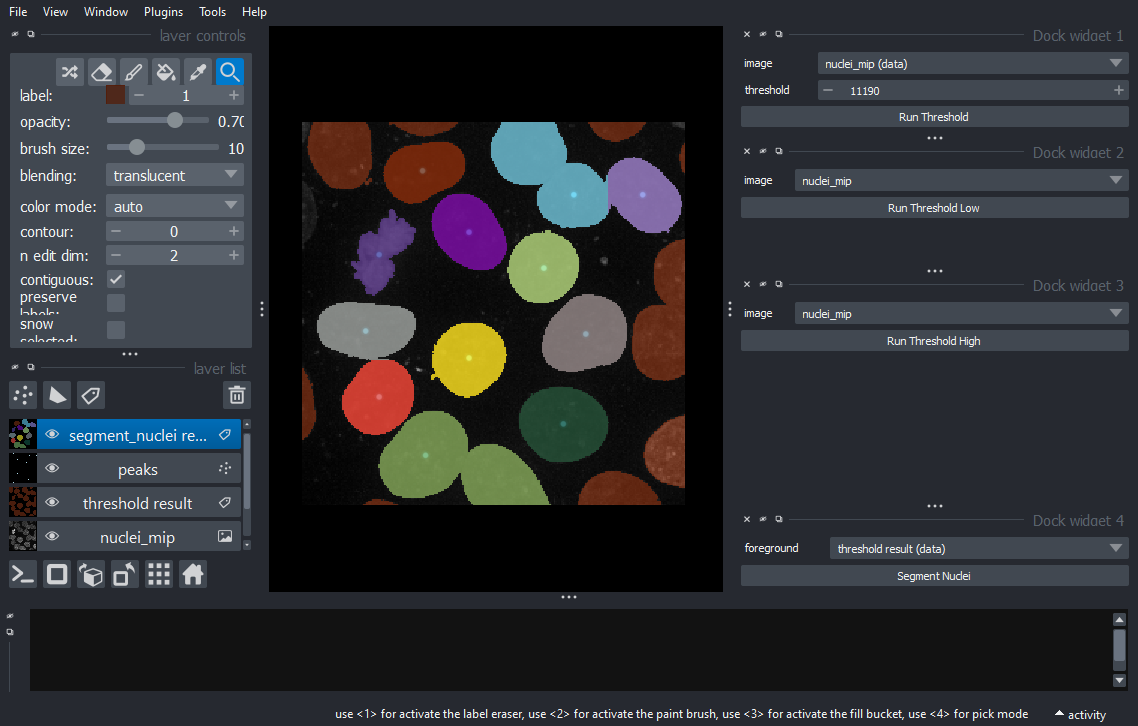

In [36]:
nbscreenshot(viewer)

## Conclusions

We've now seen how to interactively perform analyses by adding data to the napari viewer, and editing it as we moved through an analysis workflow. We've also seen how to extend the viewer with custom GUI functionality and keybindings, making analyses even more interactive!